# Week 5 - Classifying Meanings & Documents

Recall that Week 1 of this course focused on how to find and extract text data, while weeks 2 through 4 each covered a different type of content representations:

2. computational linguistics (e.g., keyword count)
3. clustering and topic modeling (e.g., LDA)
4. embeddings (e.g., _word2vec_)

Now we show how classification, arguably the most common social science task, can be done with different representations. Note that the second representation, *clustering*, allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. Classification, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

We will show how to use a variety of classification methods, including Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
# import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Annotations

This is a course on "computational" content analysis, but the best computer today is arguably still the human brain. Our aim is to augment human intelligence and scholarship. One of the most important strategies is to have real, live _Homo sapiens_ annotate text, assigning numbers or categories to individual texts. We can computationally compare annotations across humans, and we can use annotations to train computational models.

Let's take a quick look at Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" style="width:500px">

In [2]:
# Remember if you are on Google Colab, you need to upload or `git clone` the datafile
# and your path will probably be something like "#content/drive/MyDrive//data/pyAnno/testdata_numerical.txt"
x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [3]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [4]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [5]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [6]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


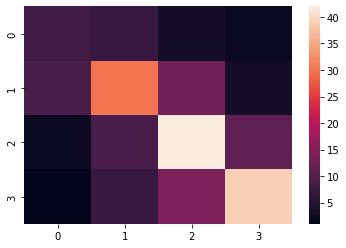

In [7]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [8]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [9]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [10]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [11]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [12]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


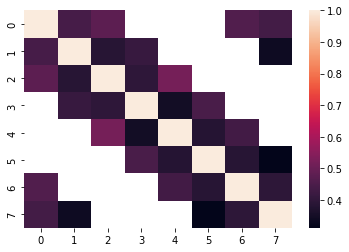

In [13]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [14]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [15]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [16]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

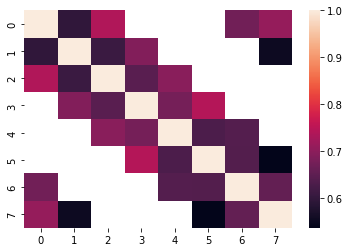

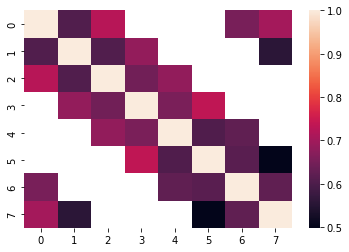

In [17]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [18]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.651721932117508 0.63808488688039


## <font color="red">*Exercise 1*</font>

<font color="red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the [MTurk slides on Canvas](https://canvas.uchicago.edu/courses/39937/files/6674661?wrap=1), or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

Here I'm asking 4 friends annotating on 50 movie reviews for Spiderman. `1` is negative, `2` is somewhat negative, `3` is neutral, `4` is somewhat positive, and `5` is positive.

In [2]:
df = pandas.read_csv('annotation.csv', header=None)
x = df.to_numpy()
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

In [667]:
anno.labels

[1, 2, 3, 4, 5]

### Inter-coder agreement

First, let's see cohens kappa between raters since it takes into probability of chance agreement into account:

[[1.         0.45708376 0.55912863 0.59411466]
 [0.45708376 1.         0.41270689 0.34043633]
 [0.55912863 0.41270689 1.         0.41565041]
 [0.59411466 0.34043633 0.41565041 1.        ]]


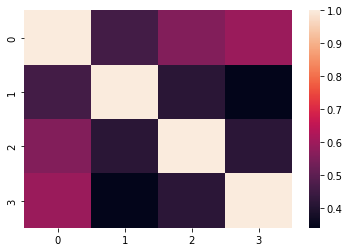

In [65]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)
ax = seaborn.heatmap(m)
plt.show()

It shows a relatively high agreement. However, we know that our data is ordinal, it is better for us to study the Krippendorff's $\alpha$ between the 4 coders.

In [66]:
krippendorffs_alpha(anno.annotations[::])

0.8196608783843713

We can see that the inter-coder agreement is pretty high. It is more than 0.800, which means that our coding is very reliable.

Since the number does not indicates real values, we cannot study the correlation.

# Simple Simulated Examples for Classification

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

We use the popular `train_test_split()` function from `sklearn`, and the data pattern function source code is copied below for your convenience from `lucem_illud`'s [cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py) file.

In [19]:
def random(numPerCategory = 500):
    datDict = {
        'vect' : [np.random.rand(2) * 2 - 1 for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def andSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        y = np.random.random_sample() * 2 - 1
        if noise >= 0:
            x = np.random.random_sample() - cat - (np.random.random_sample() - cat) * noise
        else:
            x = (1 - noise * np.random.random_sample()) - cat
        return np.array([x, y])
    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def xorSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        if cat == 1:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        else:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        return np.array([x, y])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def targetSplit(noise = 0, numPerCategory = 500, innerRad = .3):
    def genPoint(cat):
        if cat == 0:
            r = np.random.random_sample() * innerRad + (1 - innerRad) * np.random.random_sample() * noise
        else:
            r = np.random.random_sample() * (1 - innerRad) + innerRad - innerRad * np.random.random_sample() * noise
        eta = 2 * np.pi * np.random.random_sample()
        return np.array([r * np.cos(eta), r * np.sin(eta)])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def multiBlobs(noise = 0, numPerCategory = 500, centers = 5):
    if isinstance(centers, int):
        n_samples = numPerCategory * centers
    else:
        n_samples = numPerCategory * len(centers)
    X, y = sklearn.datasets.make_blobs(n_samples=n_samples, centers=centers, cluster_std = (.8 * (noise * 2 + 1)))
    datDict = {
        'vect' : list(X),
        'category' : y,
    }
    return pandas.DataFrame(datDict)

In [20]:
noise = .2

#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.random(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)

We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

In [21]:
dfTrain

,vect,category
986,"[0.006493116350478253, 0.1128783636769896]",0
125,"[0.24482175271646547, 0.40007698167915906]",1
689,"[0.2934067791023947, 0.37833919016925277]",1
747,"[-0.7348032930187396, -0.12248305630315563]",1
502,"[0.15826058685839234, 0.015751302749650472]",0
...,...,...
576,"[0.1028964693286819, -0.0005337136610968799]",0
5,"[0.01810762704852632, 0.4302740544712949]",1
977,"[-0.3982119418973302, -0.6777840876845724]",1
606,"[0.03499285100227495, 0.3294109196459046]",0


So, dfTrain has two columns, vect and category. We can plot this with `plotter()` from [lucem_illud/lucem_illud/cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py). Here's the source code:

In [22]:
def plotter(df):
    fig, ax = plt.subplots(figsize = (10,10))
    pallet = seaborn.color_palette(palette='rainbow', n_colors= len(set(df['category'])))
    for i, cat in enumerate(set(df['category'])):
        a = np.stack(df[df['category'] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    ax.axis('off')
    plt.show()
    plt.close()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


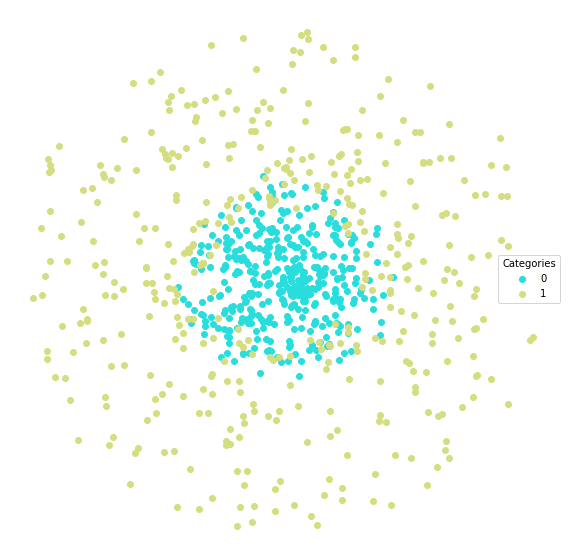

In [23]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [24]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

We're using sklearn here. What is sklearn? It's an open source machine learning library for Python. We use sklearn because it features various machine learning algorithms and it works well with NumPy library. You don't need to understand the sklearn package in detail for the moment, but let's see what methods and attributes sklearn has, because we're going to use some of them:

In [25]:
dir(sklearn)

['__SKLEARN_SETUP__',
 '__all__',
 '__builtins__',
 '__cached__',
 '__check_build',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_config',
 '_distributor_init',
 '_loss',
 'base',
 'clone',
 'config_context',
 'datasets',
 'decomposition',
 'dummy',
 'ensemble',
 'exceptions',
 'externals',
 'feature_extraction',
 'get_config',
 'linear_model',
 'logger',
 'logging',
 'metrics',
 'model_selection',
 'neighbors',
 'neural_network',
 'os',
 'preprocessing',
 'random',
 'set_config',
 'setup_module',
 'show_versions',
 'svm',
 'sys',
 'tree',
 'utils']

Now we fit the model by giving it our training data

In [26]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

KNeighborsClassifier(weights='distance')

Here, "stack" function is used. Why did we use stack function here? This is because dfTrain['vect'] is a sequence, while clf.fit() takes an array element. Let's see what dfTrain['vect'] looks like:

In [27]:
dfTrain['vect']

986      [0.006493116350478253, 0.1128783636769896]
125      [0.24482175271646547, 0.40007698167915906]
689       [0.2934067791023947, 0.37833919016925277]
747     [-0.7348032930187396, -0.12248305630315563]
502     [0.15826058685839234, 0.015751302749650472]
                           ...                     
576    [0.1028964693286819, -0.0005337136610968799]
5         [0.01810762704852632, 0.4302740544712949]
977      [-0.3982119418973302, -0.6777840876845724]
606       [0.03499285100227495, 0.3294109196459046]
796      [0.19001889886534581, 0.25451402795388595]
Name: vect, Length: 800, dtype: object

And let's see what np.stack(dfTrain['vect']) does:

In [28]:
np.stack(dfTrain['vect'])

array([[ 0.00649312,  0.11287836],
       [ 0.24482175,  0.40007698],
       [ 0.29340678,  0.37833919],
       ...,
       [-0.39821194, -0.67778409],
       [ 0.03499285,  0.32941092],
       [ 0.1900189 ,  0.25451403]])

As you can see, stack function takes a sequence of arrays (which have the same shape) and joins them along a new axis.

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set. These `lucem_illud` functions are in [metrics.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/metrics.py), and we will skip copying source code this time due to length.

In [29]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.13,0.868101,0.883929,0.846330,0.883929
1,0.13,0.868101,0.852273,0.791369,0.852273


This lets us look at which classes do better:

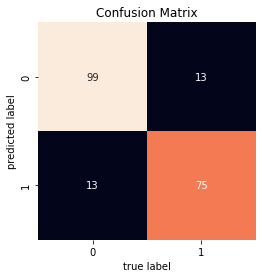

In [30]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

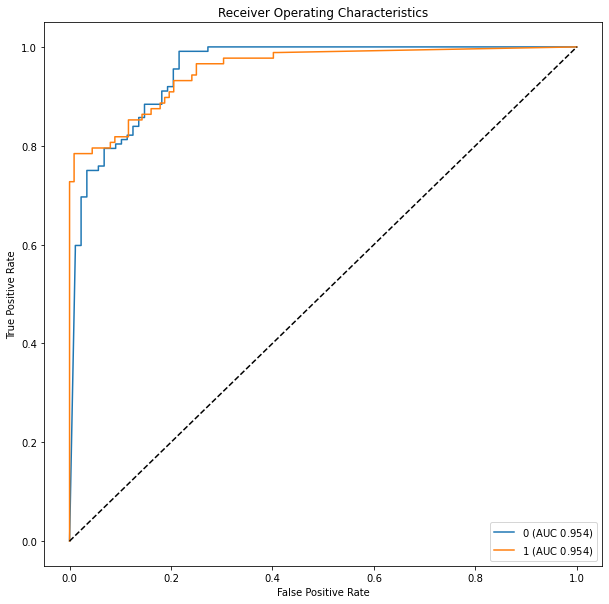

In [31]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


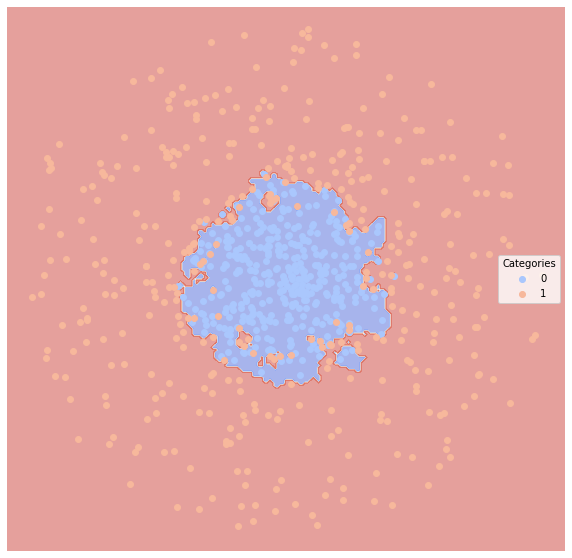

In [32]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [33]:
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(), test_size=.2)

/Users/luzhang/opt/anaconda3/envs/content/lib/python3.7/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Loading Reddit data
Converting to vectors


In [34]:
#Classical Regression
clf = sklearn.linear_model.LogisticRegression()

#Bayes
# clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [35]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

LogisticRegression()

In [36]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Bad Roommates,0.012500,0.983192,0.974684,0.956258,0.974684
Relationships,0.012500,0.978703,0.986842,0.958262,0.961538
Tales From Tech Support,0.015625,0.985372,0.951220,0.942304,0.987342
Weeaboo Tales,0.003125,0.994048,1.000000,0.991220,0.988095


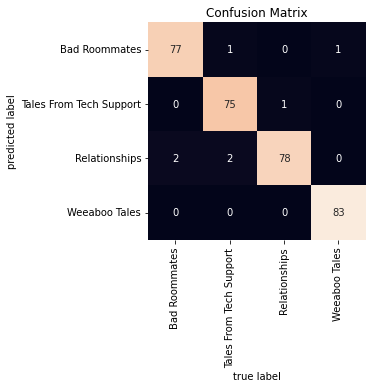

In [37]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

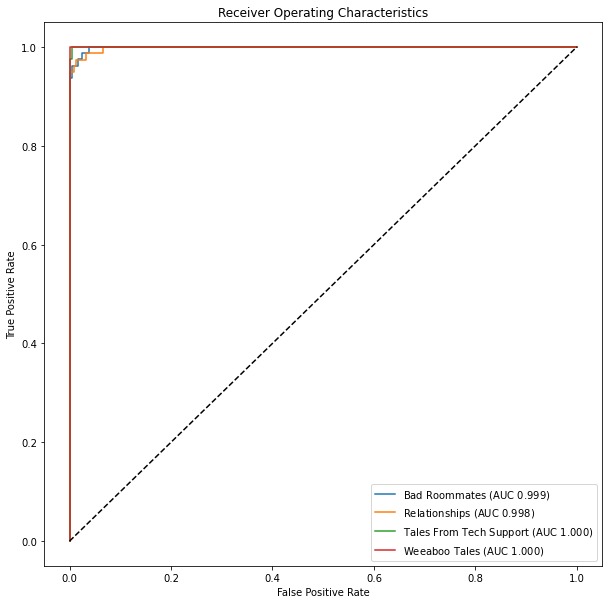

In [38]:
lucem_illud.plotMultiROC(clf, dfTest)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

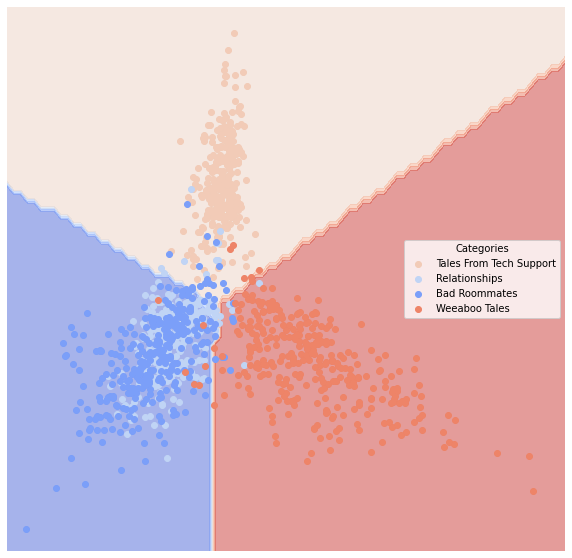

In [39]:
lucem_illud.plotregions(clf, dfTrain)

## <font color="red">*Exercise 2*</font>

<font color="red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<font color="red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

# All the models are in the notebook called `models_for_ex2.ipynb`
# The description of the classifiers:

## when noise =.2
### for random split
None of the classifiers are doing a very good job. Most of them either cannot classify the sample correctly or are over fitting

### for andSplit
KNeighbor is doing the best job. From the region plot, I think Decision Tree and Random Forest is probably overfitting. So even they have almost the same AUC (Radom Forest with even lower error rate), I still think the KNeighbot is the best

### for xorSplit
KNeighbor, again, is doing the best job with AUS around 0.92. I's say that classifiers afer KNeighbor (including DT, Random Forest, neural network, and gradient boosting) are good enough.

### for targetSplit
Linear methods are not doing good in this split. None linear/ploynominal methods like Bayes, KNeighbor, DT, Random Forest, neural network, and gradient boosting are doing well. I would prefer Bayes since it's the simplest and thus fast. 

### for multiBlobs
The symbolist methods (DT and random forest) and gradient boosting are highly likely to be overfitting. The polynomial analogize method is the best. Other methods like classcial regression, Bayes, and KNN are doing good as well.

## when noise =.4
### for random split
Similar result since random split does not takein noise as an argument. Just another random example.

### for andSplit
Similar to the when noise=.2, yet the DT and Random Forest have a significant decrease in AUS and increase in error rate. This aglins with our finding above about overfitting.

### for xorSplit
All classifiers are with lower AUC, overall pattern similar to when noise=.2

### for targetSplit
Similar to the findings when noise=.2. The DT or random forest is showing a tendency of overfitting. Neural network, suprisingly, is doing a pretty good job without overfitting. However, I would think Bayes is the best method.

### for multiBlobs
Similar to the previous findings. What's different: KNN is also overfitting in this case.

## Empricial Datasets
### Newsgroups
Neural network calssifier is doing the best. While classical regression and Bayes are producing good enough result and are simpler models. KNeighbor is overfitting, while the other methods are not performing well.

### Senate Small
Linear models is the best in this case. Although models like gradient boosting, DT, Random Forest, etc. are producing result with very high AUS and low error rate, based on the region plot, I believe the Linaer Analogize model and the classifical linear regression model are the best for the Senate Small dataset.

### Senate Large
The points are overlapping with each other, so just like the random split, I don't think the classifiers are doing a good job in this case, even they have low error rate and high AUC. Most of them get the high result by classifying most, if not all, to Kerry (or Kennedy).

### Email Spam
Like Senate Large, classifiers are getting high score by classifying everything to not spam. We probably need a more balanced data. The KNeighbors is trying very hard but still fails. 

# Stretch: AdaBoost
## for artificial dataset (xorSplit)

In [72]:
noise=.2
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)

ERROR! Session/line number was not unique in database. History logging moved to new session 845


In [78]:
clf = sklearn.ensemble.AdaBoostClassifier(n_estimators=50, learning_rate=1)
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.52,0.480132,0.494949,0.505461,0.475728
1,0.52,0.480132,0.465347,0.475477,0.484536


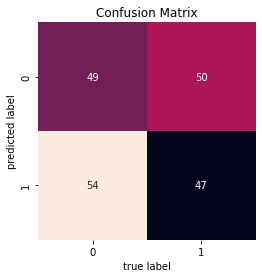

In [74]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

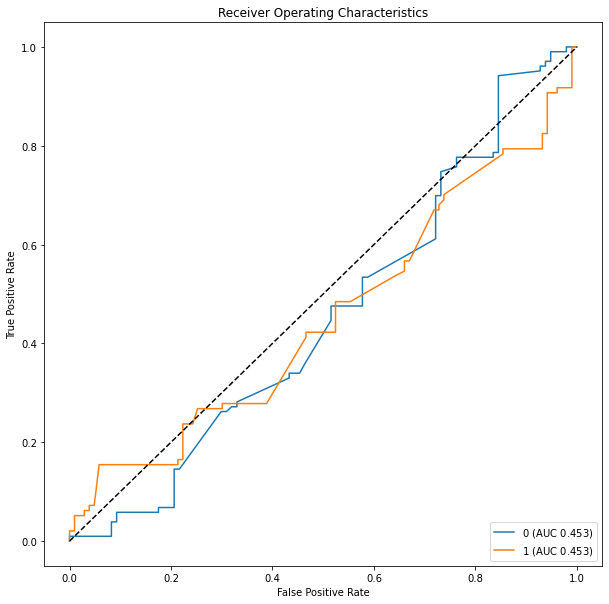

In [75]:
lucem_illud.plotMultiROC(clf, dfTest)

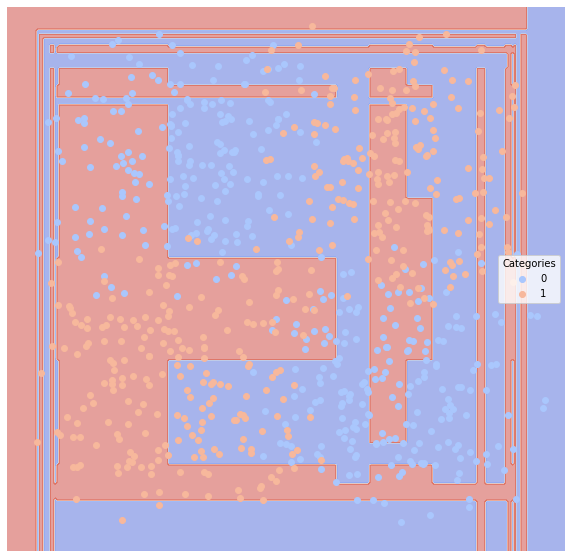

In [76]:
lucem_illud.plotregions(clf, dfTrain)

## for real dataset (Senate Small)

In [79]:
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(), test_size=.2)

Loading senate data
Converting to vectors


/Users/luzhang/opt/anaconda3/envs/content/lib/python3.7/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [80]:
clf = sklearn.ensemble.AdaBoostClassifier(n_estimators=50, learning_rate=1)
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Clinton,0.002924,0.997475,1.000000,0.997873,0.994949
Obama,0.002924,0.997475,0.993103,0.993103,1.000000


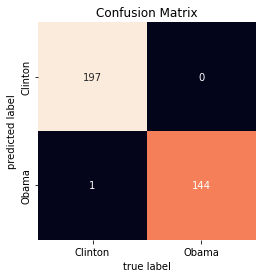

In [81]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

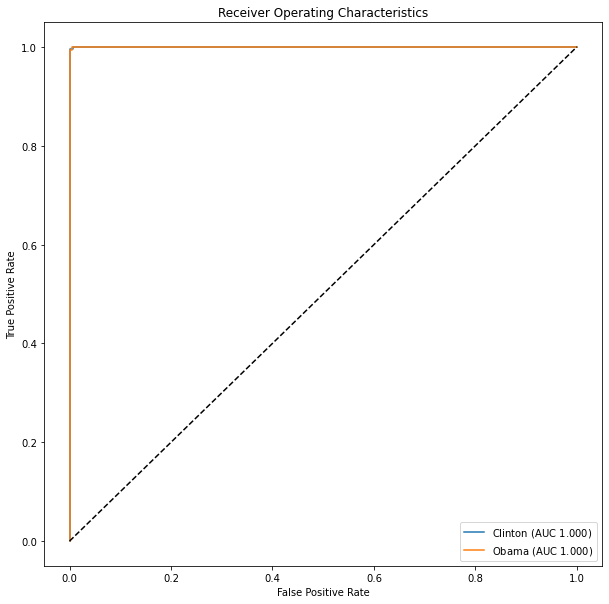

In [82]:
lucem_illud.plotMultiROC(clf, dfTest)

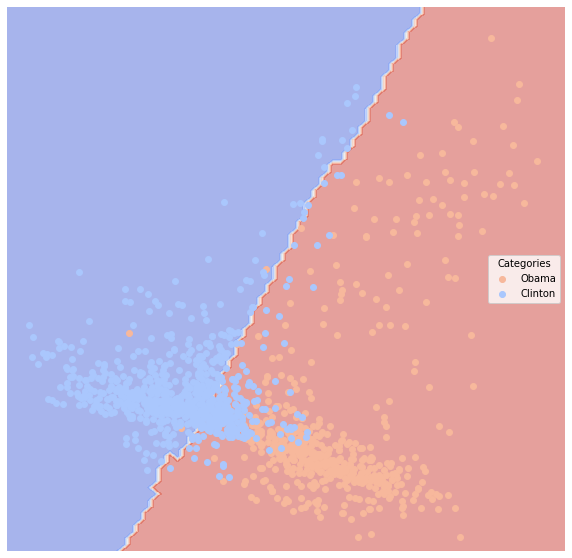

In [83]:
lucem_illud.plotregions(clf, dfTrain)

The AdaBoost Classifier is one of the interative ensemble boosting classifier. It uilds a strong classifier by combining multiply classifiers sot that the accuracy score would be improved. 

We know that the base estimator by default for adaboosting is Decision Tree. For the ariticial dataset, I choose xorSplit to see if the performance of boosting DT can be better than KNN. We can see that the multilayer preformance actually decreases. This is probably because the model is overfitting our training data as shown in the plot region.

For real dataset, I just randomly choose Senate Small. AdaBoost Classifier is actually performing the same as a single layer Decision Tree, which fits amazingly well on the dataset. 

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [40]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

I'm pretty sure that you're all familiar with pandas, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates data frame, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using pandas.read_csv function, we take in the csv file and convert it into a data frame. 

In [41]:
type(ObamaClintonReleases)

pandas.core.frame.DataFrame

It's a DataFrame! and it looks like this:

In [42]:
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama
...,...,...,...,...,...,...
1704,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton285.txt,raw/Clinton/1Sep2005Clinton285.txt,September 1 2005 Senator Clinton Visit Infoto...,Clinton
1705,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton286.txt,raw/Clinton/1Sep2005Clinton286.txt,September 1 2005 Senator Clinton Announces Ex...,Clinton
1706,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton287.txt,raw/Clinton/1Sep2005Clinton287.txt,September 1 2005 Senator Clinton Joins Local ...,Clinton
1707,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2006Clinton207.txt,raw/Clinton/1Sep2006Clinton207.txt,September 1 2006 Clintons Meet with Cazenovia...,Clinton


Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [43]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [44]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/Users/luzhang/opt/anaconda3/envs/content/lib/python3.7/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Let's split the data into training data and testing data.

In [45]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(ObamaClintonReleases, test_size=holdBackFraction)

In [46]:
print(len(train_data_df))
print(len(test_data_df))

1367
342


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud.generateVecs()` will help with this but for now we are doing it the long way):

In [47]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

The core function here is TfidfVectorizer, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means term frequency-inverse document frequency, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents. 

Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean? 

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to l2, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to l1, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1. 

fit_transform() literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform. 

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [48]:
TFVects.shape

(1367, 11189)

We can save this in the dataframe to make things easier

In [49]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Looks simple, but we need to know what todense() does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11349 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [50]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [51]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


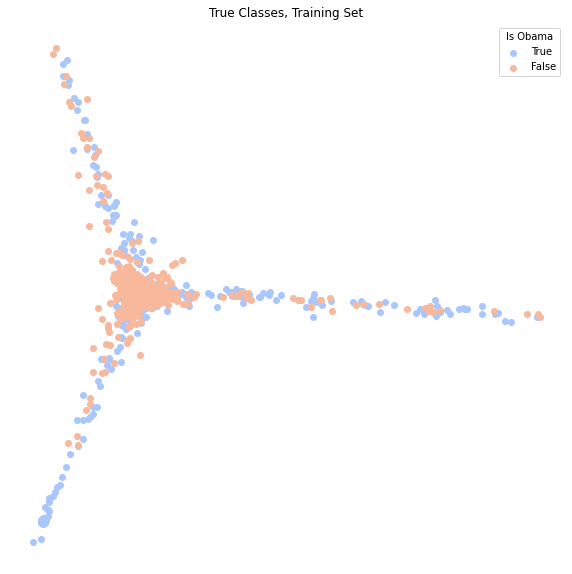

In [52]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

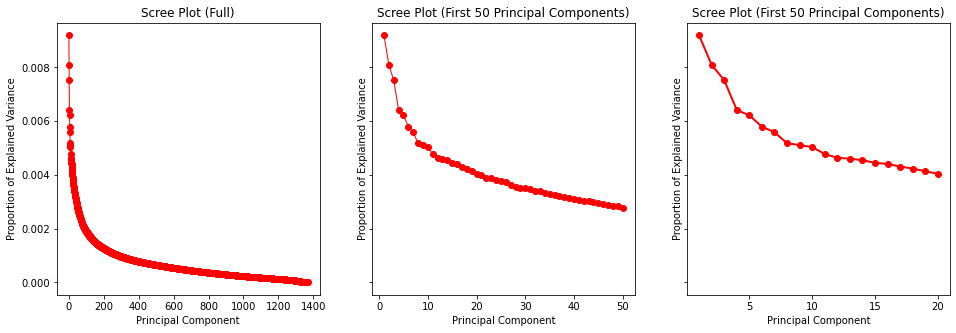

In [53]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [54]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [55]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression()

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [56]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6693489392831017

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [57]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6578947368421053

Slightly poorer. How about using more dimensions (40)?

In [58]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.745427944403804
Testing:
0.7105263157894737


Or still more (100)?

In [59]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8324798829553768
Testing:
0.7719298245614035


Or even more (200)!

In [60]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8763716166788588
Testing:
0.7953216374269005


This is becoming ridiculous (400)!

In [61]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9239209948792977
Testing:
0.7982456140350878


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [62]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.964155084125823


Train the model using training data, and then test it on the testing data.

In [63]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8187134502923976


81% accuracy seems like the best we can get by using a logistic regression.

## <font color="red">*Exercise 3*</font>

<font color="red">In the cells immediately following, perform logistic regression classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk in Exercise 1). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [3]:
df = pandas.read_csv('data.csv')
df

,labelled,score,text
0,Y,5,Loved it! Can’t wait until I can buy it and wa...
1,Y,5,"wowwww really good movie, you see you can make..."
2,Y,4,Started slow but got better!
3,Y,3,Spiderman: Into the Spiderverse did it better ...
4,Y,5,whole movie was great
...,...,...,...
65,N,0,Just ok. Storyline was kinda slow
66,N,0,Was exciting! Liked special effects! Good posi...
67,N,0,Worst movie ive ever watched. Its just so frus...
68,N,0,best acting in a superhero film.


Since the sample is very small, we categorize score that is 4 or 5 to positive, and score from 1-3 to neutral or negative.

In [4]:
df['category'] = [(s==5 or s==4) for s in df['score']]
df

,labelled,score,text,category
0,Y,5,Loved it! Can’t wait until I can buy it and wa...,True
1,Y,5,"wowwww really good movie, you see you can make...",True
2,Y,4,Started slow but got better!,True
3,Y,3,Spiderman: Into the Spiderverse did it better ...,False
4,Y,5,whole movie was great,True
...,...,...,...,...
65,N,0,Just ok. Storyline was kinda slow,False
66,N,0,Was exciting! Liked special effects! Good posi...,False
67,N,0,Worst movie ive ever watched. Its just so frus...,False
68,N,0,best acting in a superhero film.,False


In [5]:
df['tokenized_text'] = df['text'].apply(lambda x: lucem_illud.word_tokenize(x))
df['normalized_text'] = df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/Users/luzhang/opt/anaconda3/envs/content/lib/python3.7/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


We split the data based on if it has a label (or coded). 50 rows are coded, and 20 rows are not.

In [6]:
df_coded = df.loc[df['labelled'] == 'Y']
df_uncoded = df.loc[df['labelled'] == 'N']

In [676]:
holdBackFraction = .4
train_data_df, test_data_df = sklearn.model_selection.train_test_split(df_coded, test_size=holdBackFraction)

In [677]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')

# train data 
TFVects = TFVectorizer.fit_transform(train_data_df['text'])
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In [678]:
# test data
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

In [679]:
# uncoded data
TFVects_test = TFVectorizer.transform(df_uncoded['text'])
df_uncoded['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

/Users/luzhang/opt/anaconda3/envs/content/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### We first fit logistic regression on `vect`

In [680]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

LogisticRegression()

In [681]:
print("Training:")
print(logistic.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.8666666666666667
Testing:
0.45


#### Then we try various PCA and find the best

In [682]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))
train_data_df['pca'] = [r for r in reduced_data]

reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]

In [683]:
# PCA
logistic.fit(np.stack(train_data_df['pca'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca'], axis=0), test_data_df['category']))

Training:
0.8666666666666667
Testing:
0.45


In [684]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.8666666666666667
Testing:
0.45


There's no differece. Probably because our sample is small and there's not much dimension for us to reduce. So we stick with the original `vect` column.

In [685]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

LogisticRegression()

We first want to see the confusion matrix for the training set, and at the regions the classifer identifies as one class or the other for the training set. 

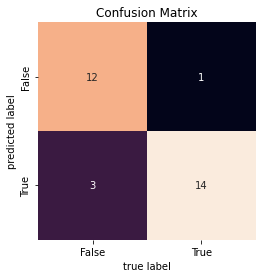

In [686]:
lucem_illud.plotConfusionMatrix(logistic, train_data_df)

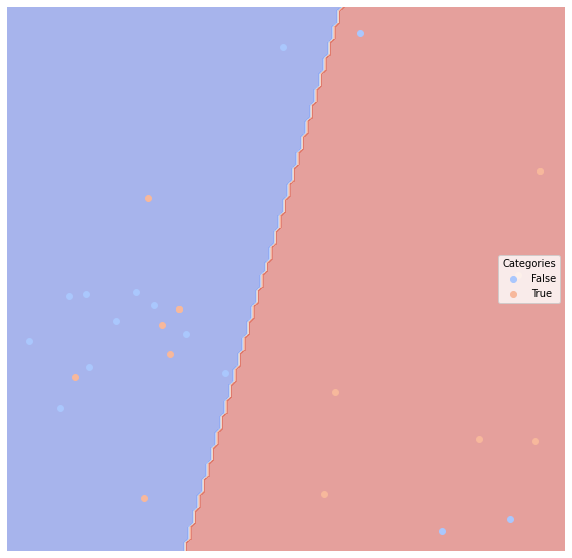

In [693]:
lucem_illud.plotregions(logistic, train_data_df)

How about it's performance of the testing set? 

In [688]:
lucem_illud.evaluateClassifier(logistic, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.55,0.429293,0.333333,0.424074,0.222222
True,0.55,0.429293,0.500000,0.518182,0.636364


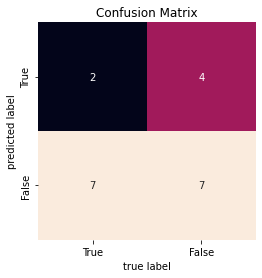

In [689]:
lucem_illud.plotConfusionMatrix(logistic, test_data_df)

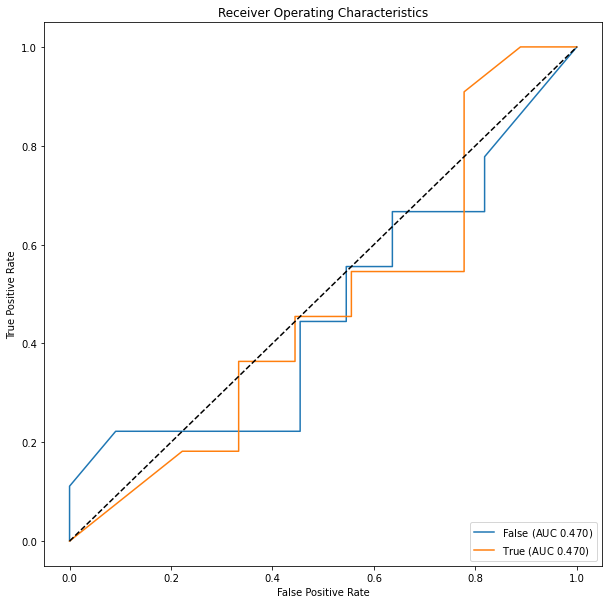

In [690]:
lucem_illud.plotMultiROC(logistic, test_data_df)

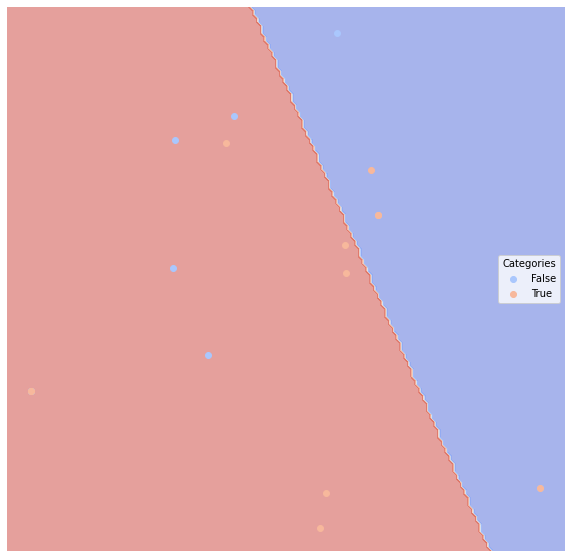

In [694]:
lucem_illud.plotregions(logistic, test_data_df)

In [692]:
df_uncoded['category'] = logistic.predict(np.stack(df_uncoded['vect'], axis=0))
df_uncoded

/Users/luzhang/opt/anaconda3/envs/content/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,labelled,score,text,category,tokenized_text,normalized_text,vect
50,N,0,Very well done. Cinematic’s were awesome!!!!,True,"[Very, well, done, Cinematic, ’s, were, awesome]","[cinematic, awesome]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
51,N,0,I liked seeing Doctor Octopus as a good guy.,False,"[I, liked, seeing, Doctor, Octopus, as, a, goo...","[liked, seeing, doctor, octopus, good, guy]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
52,N,0,Amazing movie. What made it better was adding ...,True,"[Amazing, movie, What, made, it, better, was, ...","[amazing, movie, better, adding, tobey, maguir...","[0.0, 0.0, 0.0, 0.7921008258646078, 0.0, 0.0, ..."
53,N,0,Okay someone done stepped the game up a bit,True,"[Okay, someone, done, stepped, the, game, up, ...","[okay, stepped, game, bit]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
54,N,0,AWESOME ! GR8! ANAZING !\nAWESOME ! GR8! ANAZI...,True,"[AWESOME, GR8, ANAZING, AWESOME, GR8, ANAZING,...","[awesome, gr8, anazing, awesome, gr8, anazing,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
55,N,0,Omg. If you've seen all the Spidy movies in th...,True,"[Omg, If, you, 've, seen, all, the, Spidy, mov...","[omg, ve, seen, spidy, movies, past]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
56,N,0,Likes seeing all the characters together and t...,True,"[Likes, seeing, all, the, characters, together...","[likes, seeing, characters, different, peter, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
57,N,0,very good movie from start to finish.,True,"[very, good, movie, from, start, to, finish]","[good, movie, start, finish]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
58,N,0,Movie a little too long,True,"[Movie, a, little, too, long]","[movie, little, long]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
59,N,0,"A good intention, and perhaps it was the film ...",False,"[A, good, intention, and, perhaps, it, was, th...","[good, intention, film, needed, time, good, sc...","[0.0, 0.0, 0.0, 0.31975715000878724, 0.0, 0.0,..."


We can see from the result that although the classical regression classifier is doing a good job in the training set, it is performing badly on the testing set. The accuracy rate is less than 0.5. Since we are doing a binary classification, it is even worse than a random guess. The AUC score is low (0.430). The precision scores are low, meaning that our calssifier does not have the ability of not labelling a false sample as true, or vise versa. The recall scores, meaning that our classifier cannot find all true or false samples. Overall, the model is doing better classifying true samples than false samples. This is probably because our dataset is small and imbalanced. It would be better if we have more training data for the model. 

When looking at the unlablled sample, we can obviously see that our classifier is not doing well. For instance, it classified `best acting in a superhero film` to `False`, which is obviously not correct. This phrase is positive and should be `True`. Again, we need more training data.

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

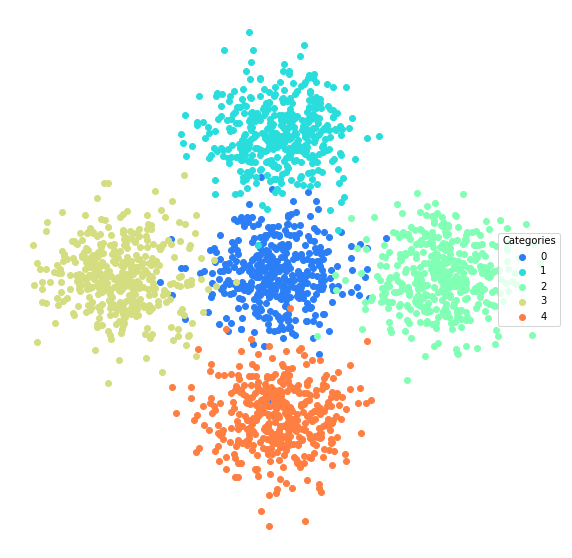

In [64]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = sklearn.model_selection.train_test_split(blobs_df, test_size=.2)
lucem_illud.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [65]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

To see what's going on visually with the classification: 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

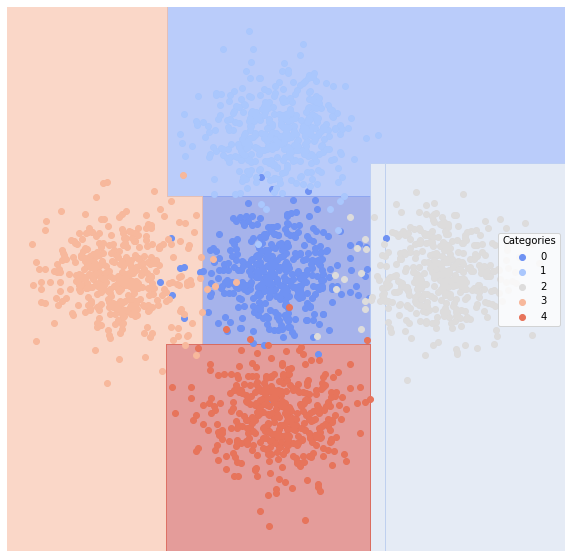

In [66]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [67]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.032,0.958025,0.905660,0.864386,0.941176
1,0.006,0.985577,1.000000,0.977154,0.971154
2,0.014,0.972856,0.964286,0.926908,0.952941
3,0.010,0.990037,0.961538,0.954018,0.990099
4,0.010,0.980206,0.990476,0.961792,0.962963


Lets look at accuracy:

In [68]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.964

What happens if we trim the tree?

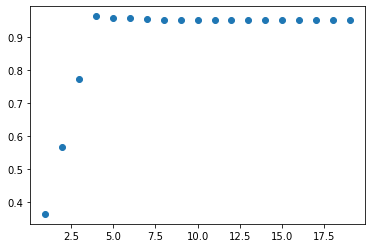

In [69]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [70]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [71]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

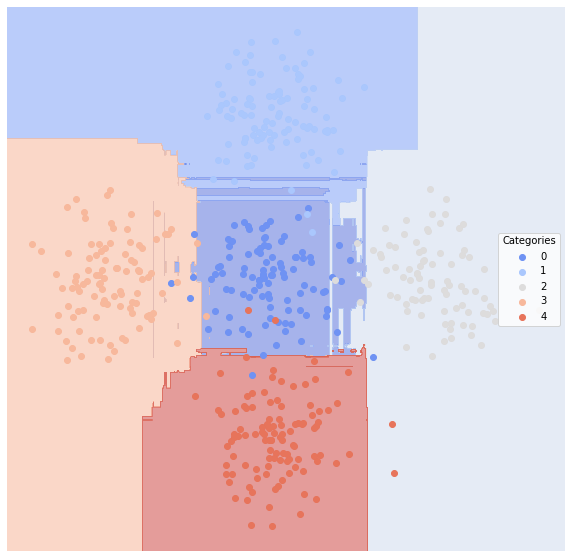

In [72]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [73]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.038,0.950611,0.887850,0.840920,0.931373
1,0.008,0.980769,1.000000,0.969538,0.961538
2,0.016,0.971651,0.952941,0.916097,0.952941
3,0.010,0.990037,0.961538,0.954018,0.990099
4,0.012,0.975576,0.990385,0.954533,0.953704


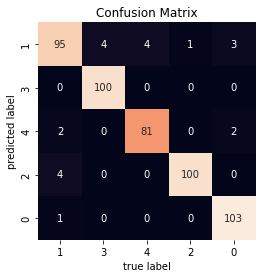

In [74]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <font color="red">*Exercise 4*</font>

<font color="red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

## Decision Tree

First we want to find which depth performs the best:

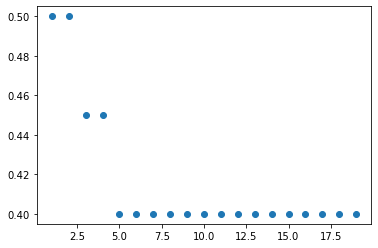

In [704]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])
    score = sklearn.metrics.accuracy_score(test_data_df['category'], tree2.predict(np.stack(test_data_df['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

It shows that the Decision Tree works the best when the max depth is low. It's probably because our sample is too small and therefore we need a fairly simple model to fit it.

In [706]:
decision_tree = sklearn.tree.DecisionTreeClassifier(max_depth=3, random_state=0)
decision_tree.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])

print("Training:")
print(decision_tree.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(decision_tree.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.7333333333333333
Testing:
0.45


First, we want to visualize it's performance on the trianing data

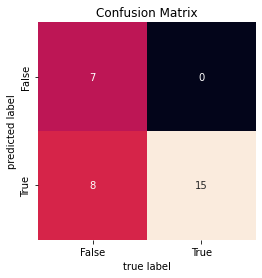

In [707]:
lucem_illud.plotConfusionMatrix(decision_tree, train_data_df)

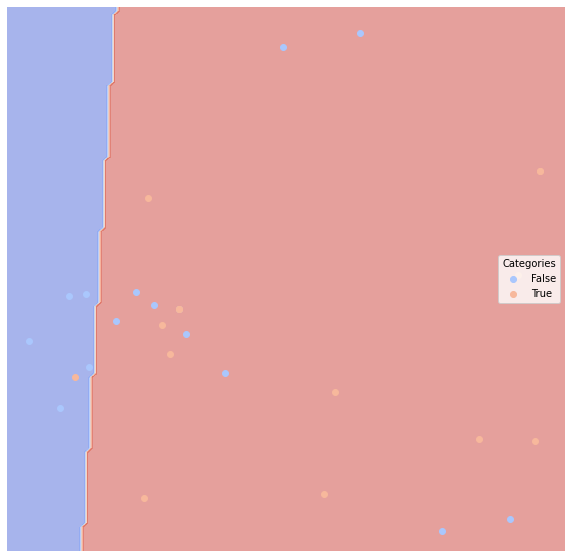

In [708]:
lucem_illud.plotregions(decision_tree, train_data_df)

How about its performance on the testing data?

In [709]:
lucem_illud.evaluateClassifier(decision_tree, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.55,0.419192,0.25,0.427778,0.111111
True,0.55,0.419192,0.50,0.513636,0.727273


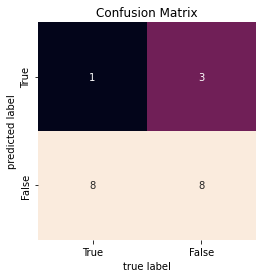

In [713]:
lucem_illud.plotConfusionMatrix(decision_tree, test_data_df)

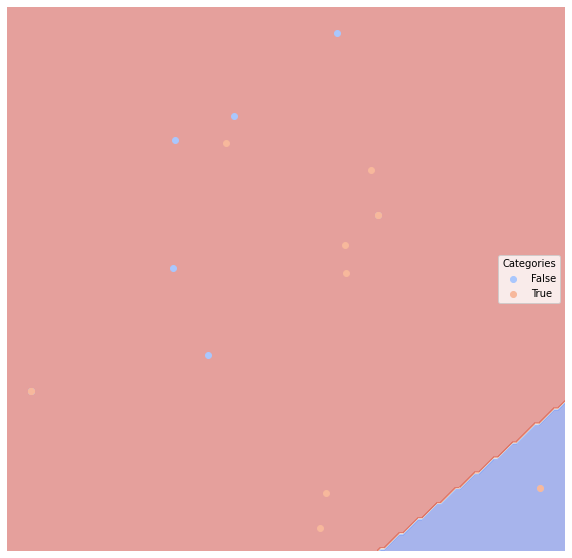

In [710]:
lucem_illud.plotregions(decision_tree, test_data_df)

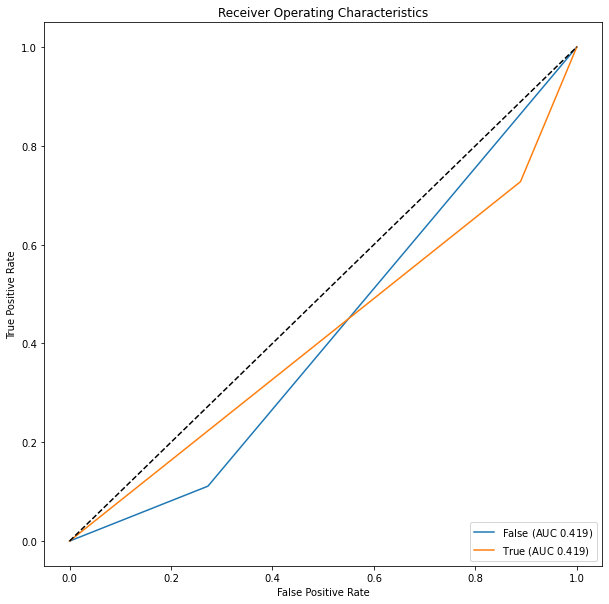

In [712]:
lucem_illud.plotMultiROC(decision_tree, test_data_df)

In [711]:
sklearn.metrics.accuracy_score(test_data_df['category'], decision_tree.predict(np.stack(test_data_df['vect'], axis = 0)))

0.45

In [77]:
df_uncoded['category'] = decision_tree.predict(np.stack(df_uncoded['vect'], axis=0))
df_uncoded

/Users/luzhang/opt/anaconda3/envs/content/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,labelled,score,text,category,tokenized_text,normalized_text,vect
50,N,0,Very well done. Cinematic’s were awesome!!!!,False,"[Very, well, done, Cinematic, ’s, were, awesome]","[cinematic, awesome]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
51,N,0,I liked seeing Doctor Octopus as a good guy.,False,"[I, liked, seeing, Doctor, Octopus, as, a, goo...","[liked, seeing, doctor, octopus, good, guy]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
52,N,0,Amazing movie. What made it better was adding ...,True,"[Amazing, movie, What, made, it, better, was, ...","[amazing, movie, better, adding, tobey, maguir...","[0.7016618220867136, 0.0, 0.5941995886087039, ..."
53,N,0,Okay someone done stepped the game up a bit,False,"[Okay, someone, done, stepped, the, game, up, ...","[okay, stepped, game, bit]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
54,N,0,AWESOME ! GR8! ANAZING !\nAWESOME ! GR8! ANAZI...,False,"[AWESOME, GR8, ANAZING, AWESOME, GR8, ANAZING,...","[awesome, gr8, anazing, awesome, gr8, anazing,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
55,N,0,Omg. If you've seen all the Spidy movies in th...,False,"[Omg, If, you, 've, seen, all, the, Spidy, mov...","[omg, ve, seen, spidy, movies, past]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
56,N,0,Likes seeing all the characters together and t...,False,"[Likes, seeing, all, the, characters, together...","[likes, seeing, characters, different, peter, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
57,N,0,very good movie from start to finish.,True,"[very, good, movie, from, start, to, finish]","[good, movie, start, finish]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85246450..."
58,N,0,Movie a little too long,True,"[Movie, a, little, too, long]","[movie, little, long]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
59,N,0,"A good intention, and perhaps it was the film ...",False,"[A, good, intention, and, perhaps, it, was, th...","[good, intention, film, needed, time, good, sc...","[0.0, 0.0, 0.3765847102332061, 0.0, 0.0, 0.0, ..."


The accuracy score for Decision Tree on the testing set is the same as logistic regression, which is lower than a random guess since we are having a binary classification task. The AUC, recall, and precision scores are even lower. We can see that this greedy algorithm is trying to classify as many points as possible into `true` to achieve a lower error rate (although the result is still bad). 

The uncoded samples cannot be predict accuraly based on our model as well.

## Random Forest

Similar to Decision Tree, we want to find what is the optimal depth.

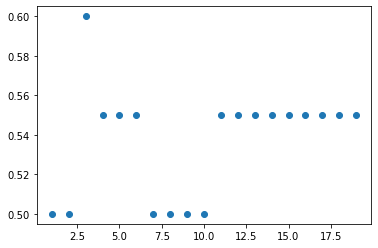

In [714]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.ensemble.RandomForestClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])
    score = sklearn.metrics.accuracy_score(test_data_df['category'], tree2.predict(np.stack(test_data_df['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

The best depth is at approximately 3.

In [718]:
random_forest = sklearn.ensemble.RandomForestClassifier(max_depth=3, random_state=0)
random_forest.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

print("Training:")
print(random_forest.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(random_forest.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.8333333333333334
Testing:
0.6


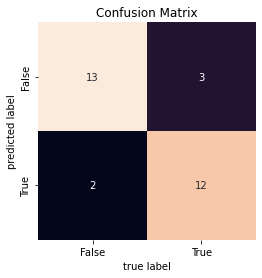

In [721]:
lucem_illud.plotConfusionMatrix(random_forest, train_data_df)

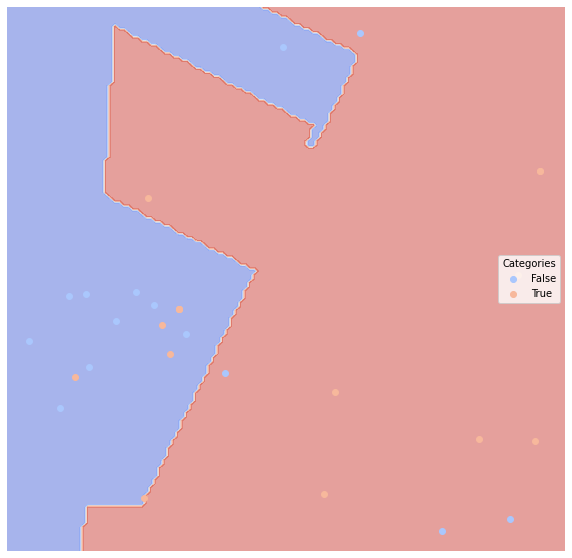

In [720]:
lucem_illud.plotregions(random_forest, train_data_df)

How about its performance on our testing data?

In [722]:
lucem_illud.evaluateClassifier(random_forest, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.4,0.575758,0.6,0.500000,0.333333
True,0.4,0.575758,0.6,0.590909,0.818182


ERROR! Session/line number was not unique in database. History logging moved to new session 819


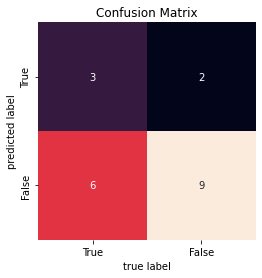

In [723]:
lucem_illud.plotConfusionMatrix(random_forest, test_data_df)

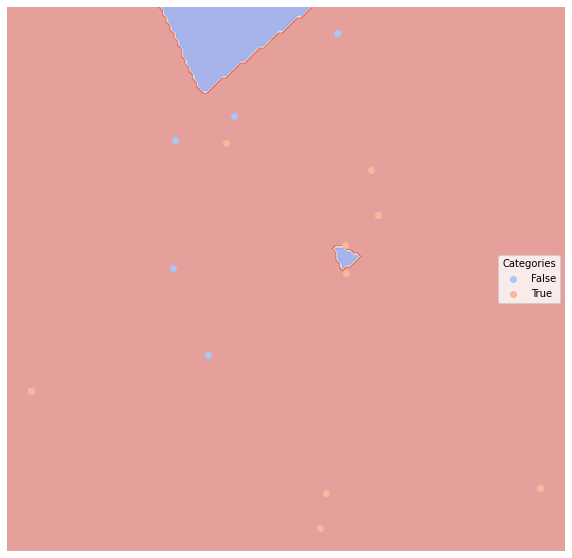

In [724]:
lucem_illud.plotregions(random_forest, test_data_df)

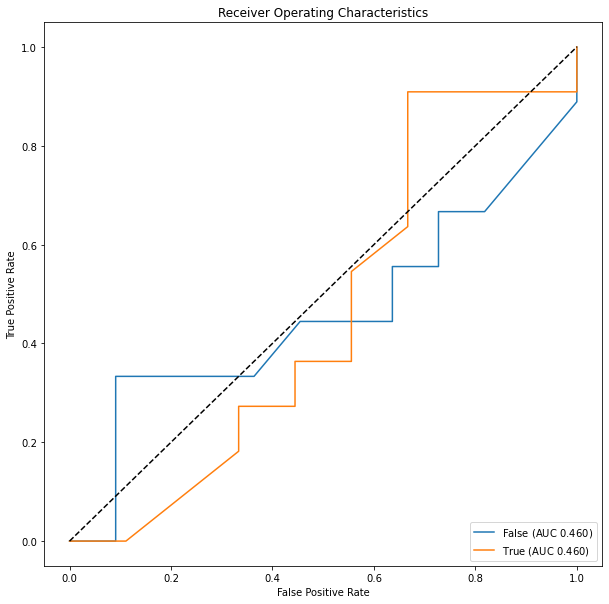

In [725]:
lucem_illud.plotMultiROC(random_forest, test_data_df)

In [81]:
sklearn.metrics.accuracy_score(test_data_df['category'],random_forest.predict(np.stack(test_data_df['vect'], axis = 0)))

0.6

In [82]:
df_uncoded['category'] = random_forest.predict(np.stack(df_uncoded['vect'], axis=0))
df_uncoded

/Users/luzhang/opt/anaconda3/envs/content/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,labelled,score,text,category,tokenized_text,normalized_text,vect
50,N,0,Very well done. Cinematic’s were awesome!!!!,True,"[Very, well, done, Cinematic, ’s, were, awesome]","[cinematic, awesome]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
51,N,0,I liked seeing Doctor Octopus as a good guy.,False,"[I, liked, seeing, Doctor, Octopus, as, a, goo...","[liked, seeing, doctor, octopus, good, guy]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
52,N,0,Amazing movie. What made it better was adding ...,True,"[Amazing, movie, What, made, it, better, was, ...","[amazing, movie, better, adding, tobey, maguir...","[0.7016618220867136, 0.0, 0.5941995886087039, ..."
53,N,0,Okay someone done stepped the game up a bit,True,"[Okay, someone, done, stepped, the, game, up, ...","[okay, stepped, game, bit]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
54,N,0,AWESOME ! GR8! ANAZING !\nAWESOME ! GR8! ANAZI...,True,"[AWESOME, GR8, ANAZING, AWESOME, GR8, ANAZING,...","[awesome, gr8, anazing, awesome, gr8, anazing,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
55,N,0,Omg. If you've seen all the Spidy movies in th...,True,"[Omg, If, you, 've, seen, all, the, Spidy, mov...","[omg, ve, seen, spidy, movies, past]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
56,N,0,Likes seeing all the characters together and t...,True,"[Likes, seeing, all, the, characters, together...","[likes, seeing, characters, different, peter, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
57,N,0,very good movie from start to finish.,True,"[very, good, movie, from, start, to, finish]","[good, movie, start, finish]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85246450..."
58,N,0,Movie a little too long,True,"[Movie, a, little, too, long]","[movie, little, long]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
59,N,0,"A good intention, and perhaps it was the film ...",True,"[A, good, intention, and, perhaps, it, was, th...","[good, intention, film, needed, time, good, sc...","[0.0, 0.0, 0.3765847102332061, 0.0, 0.0, 0.0, ..."


The Random Forest is performing a little better than classical regression or the Decision Tree. The AUC is 0.575 and the error_rate is slightly lower. All performances have some increase. However, it is still not as good as expectly, the perdiction on uncoded sample is bad.

## Ensemble classifier by bagging trees into a random forest

In [726]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) 
bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=0) 
bag.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])

print("Training:")
print(bag.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(bag.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9666666666666667
Testing:
0.45


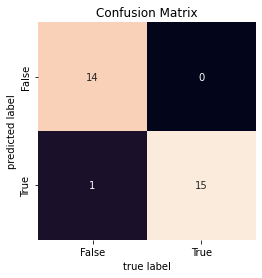

In [728]:
lucem_illud.plotConfusionMatrix(bag, train_data_df)

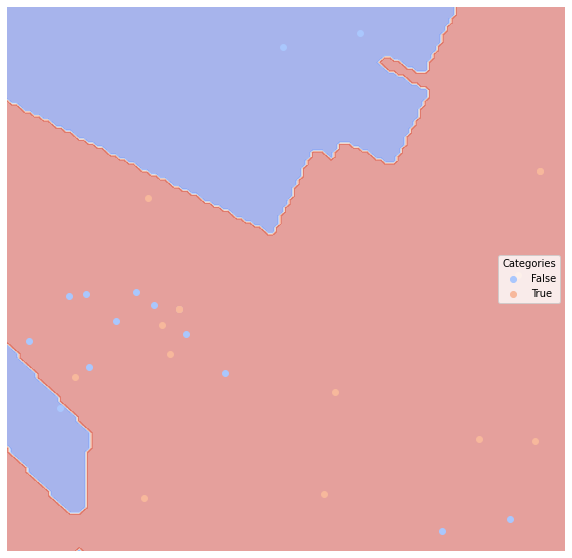

In [729]:
lucem_illud.plotregions(bag, train_data_df)

How about our testing set?

In [85]:
lucem_illud.evaluateClassifier(bag, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.65,0.358586,0.375000,0.502273,0.272727
True,0.65,0.358586,0.333333,0.398148,0.444444


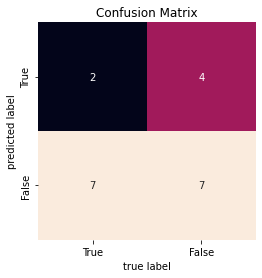

In [730]:
lucem_illud.plotConfusionMatrix(bag, test_data_df)

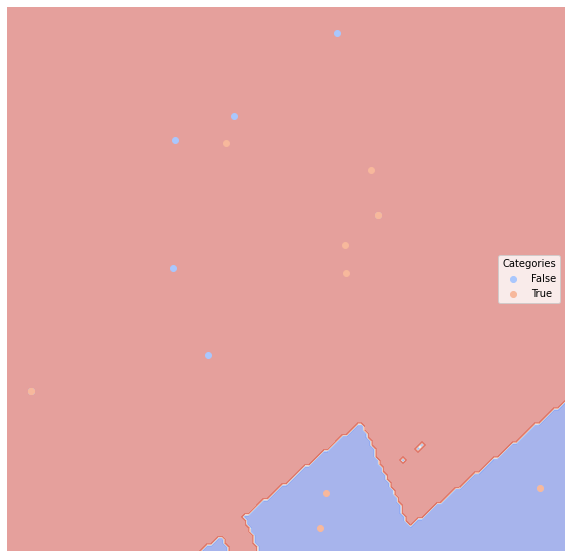

In [731]:
lucem_illud.plotregions(bag, test_data_df)

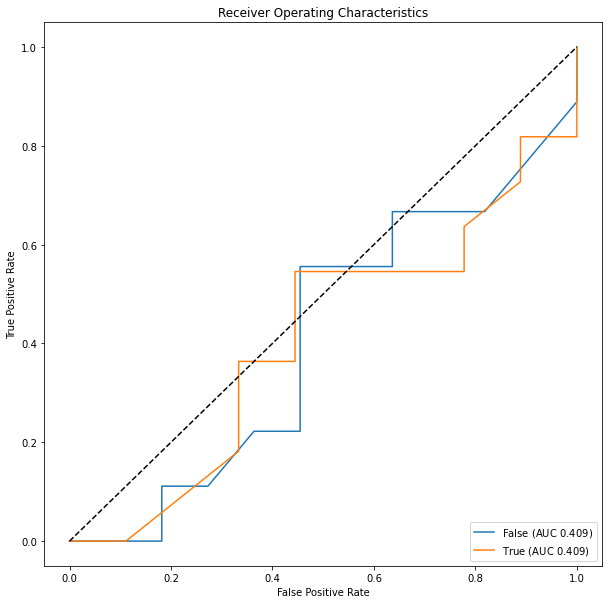

In [732]:
lucem_illud.plotMultiROC(bag, test_data_df)

In [733]:
df_uncoded['category'] = bag.predict(np.stack(df_uncoded['vect'], axis=0))
df_uncoded

/Users/luzhang/opt/anaconda3/envs/content/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,labelled,score,text,category,tokenized_text,normalized_text,vect
50,N,0,Very well done. Cinematic’s were awesome!!!!,True,"[Very, well, done, Cinematic, ’s, were, awesome]","[cinematic, awesome]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
51,N,0,I liked seeing Doctor Octopus as a good guy.,False,"[I, liked, seeing, Doctor, Octopus, as, a, goo...","[liked, seeing, doctor, octopus, good, guy]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
52,N,0,Amazing movie. What made it better was adding ...,True,"[Amazing, movie, What, made, it, better, was, ...","[amazing, movie, better, adding, tobey, maguir...","[0.0, 0.0, 0.0, 0.7921008258646078, 0.0, 0.0, ..."
53,N,0,Okay someone done stepped the game up a bit,True,"[Okay, someone, done, stepped, the, game, up, ...","[okay, stepped, game, bit]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
54,N,0,AWESOME ! GR8! ANAZING !\nAWESOME ! GR8! ANAZI...,True,"[AWESOME, GR8, ANAZING, AWESOME, GR8, ANAZING,...","[awesome, gr8, anazing, awesome, gr8, anazing,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
55,N,0,Omg. If you've seen all the Spidy movies in th...,True,"[Omg, If, you, 've, seen, all, the, Spidy, mov...","[omg, ve, seen, spidy, movies, past]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
56,N,0,Likes seeing all the characters together and t...,True,"[Likes, seeing, all, the, characters, together...","[likes, seeing, characters, different, peter, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
57,N,0,very good movie from start to finish.,True,"[very, good, movie, from, start, to, finish]","[good, movie, start, finish]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
58,N,0,Movie a little too long,True,"[Movie, a, little, too, long]","[movie, little, long]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
59,N,0,"A good intention, and perhaps it was the film ...",False,"[A, good, intention, and, perhaps, it, was, th...","[good, intention, film, needed, time, good, sc...","[0.0, 0.0, 0.0, 0.31975715000878724, 0.0, 0.0,..."


The ensemble classifier here is take a subset of the data each time, and make many randominzed estimators to fit the data. Each tree can overfit the data, but the assumption here is that the combination would do a better job. However, the the high accuracy on training set and low accuracy on testing set shows that the model is still over fitting. The AUC, precision, and recall scores are all lower than single Decision Tree. 

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data.

In [75]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus.
newsgroups.target_names #Possible categories, i.e., the newsgroups

target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


/Users/luzhang/opt/anaconda3/envs/content/lib/python3.7/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [76]:
newsgroupsDF[:5]

,text,category,source_file,tokenized_text,normalized_text
0,\n\nParadise and salvation are not the same th...,talk.religion.misc,../data\20news_home\20news-bydate-train\talk.r...,"[Paradise, and, salvation, are, not, the, same...","[paradise, salvation, thing, salvation, better..."
1,\nYou're admitting a lot more than that. You ...,talk.religion.misc,../data\20news_home\20news-bydate-train\talk.r...,"[You, 're, admitting, a, lot, more, than, that...","[admitting, lot, admitting, morals, situationa..."
2,"\n\nJesus also recognized other holy days, lik...",talk.religion.misc,../data\20news_home\20news-bydate-train\talk.r...,"[Jesus, also, recognized, other, holy, days, l...","[jesus, recognized, holy, days, like, passover..."
3,In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...,talk.religion.misc,../data\20news_home\20news-bydate-train\talk.r...,"[In, <, lsjc8cINNmc1@saltillo.cs.utexas.edu, >...","[<, lsjc8cinnmc1@saltillo.cs.utexas.edu, >, tu..."
4,"\nI'm sorry, but He does not! Ever read the F...",talk.religion.misc,../data\20news_home\20news-bydate-train\talk.r...,"[I, 'm, sorry, but, He, does, not, Ever, read,...","[m, sorry, read, commandment]"


Make a testing and training set:

In [77]:
holdBackFraction = .2
train_ng_df, test_ng_df = sklearn.model_selection.train_test_split(newsgroupsDF, test_size=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [78]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [79]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [80]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(n_neighbors=15)

In [81]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
talk.religion.misc,0.236353,0.632444,0.352459,0.250787,0.431438
soc.religion.christian,0.257259,0.539951,0.754386,0.317855,0.091102
comp.graphics,0.341463,0.621235,0.410256,0.348401,0.537815
sci.space,0.357724,0.617460,0.395556,0.343134,0.562105


And lets look at the testing data

In [82]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.24361948955916474


Let's produce another confusion matrix:

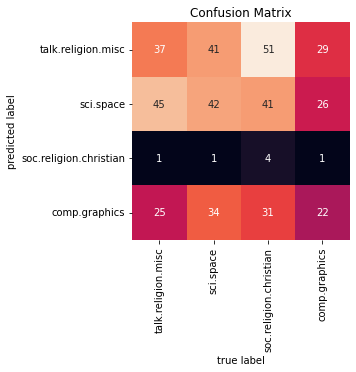

In [83]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [84]:
#lucem_illud.plotregions(clf_knearest, test_ng_df)

## <font color="red">*Exercise 5*</font>

<font color="red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [735]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
clf_knearest.fit(np.stack(train_data_df['vect'], axis = 0), train_data_df['category'])

print("Training:")
print(clf_knearest.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(clf_knearest.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.5333333333333333
Testing:
0.45


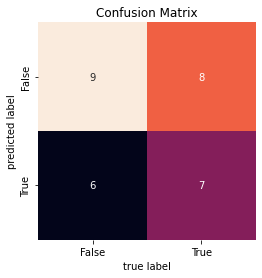

In [739]:
lucem_illud.plotConfusionMatrix(clf_knearest, train_data_df)

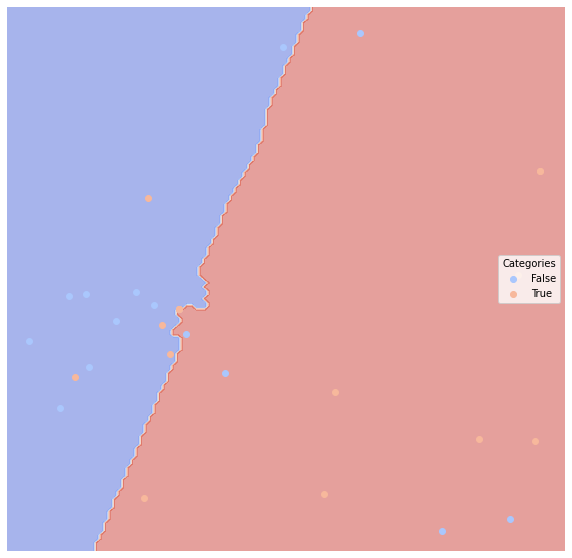

In [740]:
lucem_illud.plotregions(clf_knearest, train_data_df)

How about the model's performance on testing set?

In [741]:
lucem_illud.evaluateClassifier(clf_knearest, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.55,0.439394,0.375,0.425000,0.333333
True,0.55,0.439394,0.500,0.522727,0.545455


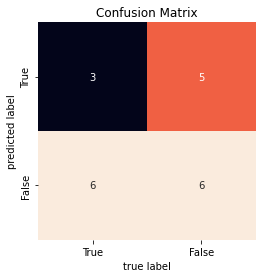

In [742]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_data_df)

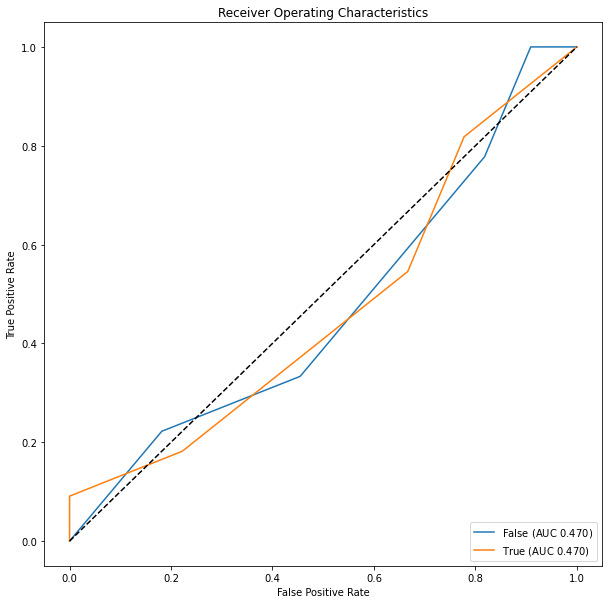

In [744]:
lucem_illud.plotMultiROC(clf_knearest, test_data_df)

In [745]:
df_uncoded['category'] = clf_knearest.predict(np.stack(df_uncoded['vect'], axis=0))
df_uncoded

/Users/luzhang/opt/anaconda3/envs/content/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,labelled,score,text,category,tokenized_text,normalized_text,vect
50,N,0,Very well done. Cinematic’s were awesome!!!!,False,"[Very, well, done, Cinematic, ’s, were, awesome]","[cinematic, awesome]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
51,N,0,I liked seeing Doctor Octopus as a good guy.,True,"[I, liked, seeing, Doctor, Octopus, as, a, goo...","[liked, seeing, doctor, octopus, good, guy]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
52,N,0,Amazing movie. What made it better was adding ...,True,"[Amazing, movie, What, made, it, better, was, ...","[amazing, movie, better, adding, tobey, maguir...","[0.0, 0.0, 0.0, 0.7921008258646078, 0.0, 0.0, ..."
53,N,0,Okay someone done stepped the game up a bit,False,"[Okay, someone, done, stepped, the, game, up, ...","[okay, stepped, game, bit]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
54,N,0,AWESOME ! GR8! ANAZING !\nAWESOME ! GR8! ANAZI...,False,"[AWESOME, GR8, ANAZING, AWESOME, GR8, ANAZING,...","[awesome, gr8, anazing, awesome, gr8, anazing,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
55,N,0,Omg. If you've seen all the Spidy movies in th...,False,"[Omg, If, you, 've, seen, all, the, Spidy, mov...","[omg, ve, seen, spidy, movies, past]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
56,N,0,Likes seeing all the characters together and t...,False,"[Likes, seeing, all, the, characters, together...","[likes, seeing, characters, different, peter, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
57,N,0,very good movie from start to finish.,True,"[very, good, movie, from, start, to, finish]","[good, movie, start, finish]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
58,N,0,Movie a little too long,True,"[Movie, a, little, too, long]","[movie, little, long]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
59,N,0,"A good intention, and perhaps it was the film ...",True,"[A, good, intention, and, perhaps, it, was, th...","[good, intention, film, needed, time, good, sc...","[0.0, 0.0, 0.0, 0.31975715000878724, 0.0, 0.0,..."


Based on the statistics, so far, KNN is producing the best result compared to all the other methods. Although it's performance is still not satisfying, I believe that by feeding the model with more data or longer paragraph, the performance will be improved.

Taking about the difference and similarity between KNN and KMeans:

They are fondamentally different since KMeans is an unsupervised machine learning, while KNN is a supervised machine learning. One does not need labelled data as input while the other need ground truth data to train the method. 

The only similarities I can think of is that: 1) they both need to specify an input `k`. For KNN the k means that the data point is assigned to the class most common among its k-nearest neighbors, while in KMeans it means we are classifying the data to k groups. 2) they both need a distance metric. 

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [85]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/Users/luzhang/opt/anaconda3/envs/content/lib/python3.7/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


We will tf.idf the data to make our vectors:

In [86]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [87]:
holdBackFraction = .2
train_redditDf, test_redditDf = sklearn.model_selection.train_test_split(redditDf, test_size=holdBackFraction)

In [88]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

SVC(kernel='linear')

...and consider the results:

In [89]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Relationships,0.018750,0.972720,0.976471,0.944075,0.954023
Tales From Tech Support,0.009375,0.994024,0.958333,0.958333,1.000000
Weeaboo Tales: stories about the extreme fans of japanese culture,0.003125,0.997951,0.987013,0.987013,1.000000
Bad Roommates: Tales of Irritation,0.012500,0.980799,0.988372,0.964053,0.965909


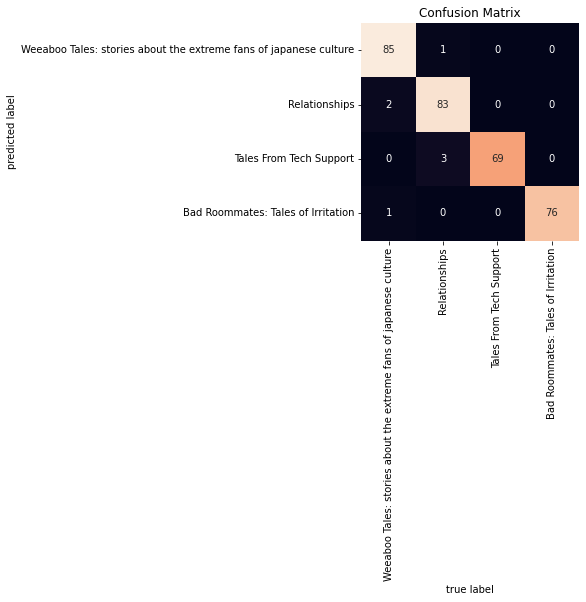

In [90]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

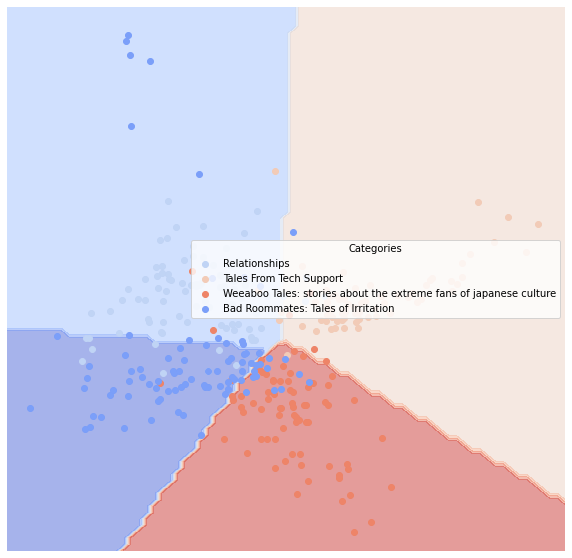

In [91]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [92]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

MLPClassifier()

In [93]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Relationships,0.015625,0.982068,0.965909,0.949954,0.977011
Tales From Tech Support,0.003125,0.998008,0.985714,0.985714,1.000000
Weeaboo Tales: stories about the extreme fans of japanese culture,0.012500,0.991803,0.950000,0.950000,1.000000
Bad Roommates: Tales of Irritation,0.018750,0.965909,1.000000,0.950568,0.931818


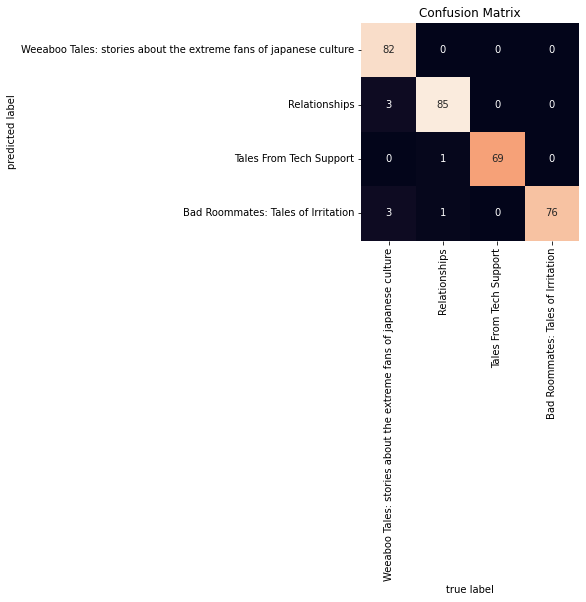

In [94]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

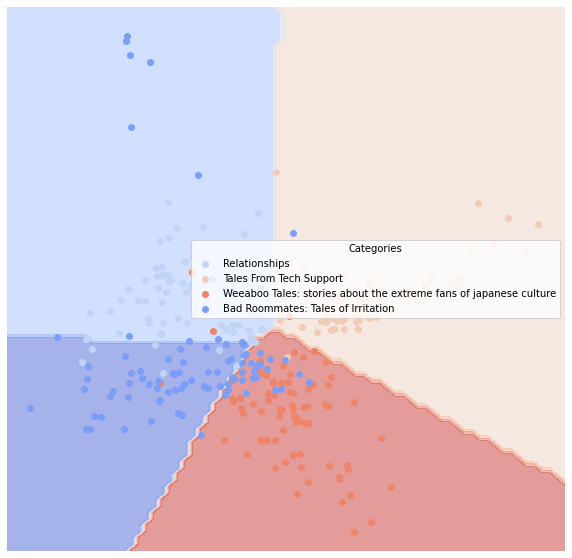

In [95]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, logistic and decision-tree approaches?

In [747]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

print("Training:")
print(clf_nn.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(clf_nn.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9666666666666667
Testing:
0.45


/Users/luzhang/opt/anaconda3/envs/content/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


View its performance on the testing set:

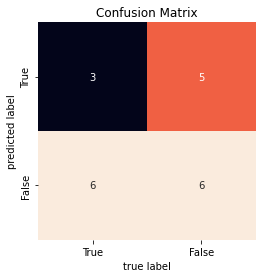

In [748]:
lucem_illud.plotConfusionMatrix(clf_nn, test_data_df)

In [749]:
lucem_illud.evaluateClassifier(clf_nn, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.55,0.439394,0.375,0.425000,0.333333
True,0.55,0.439394,0.500,0.522727,0.545455


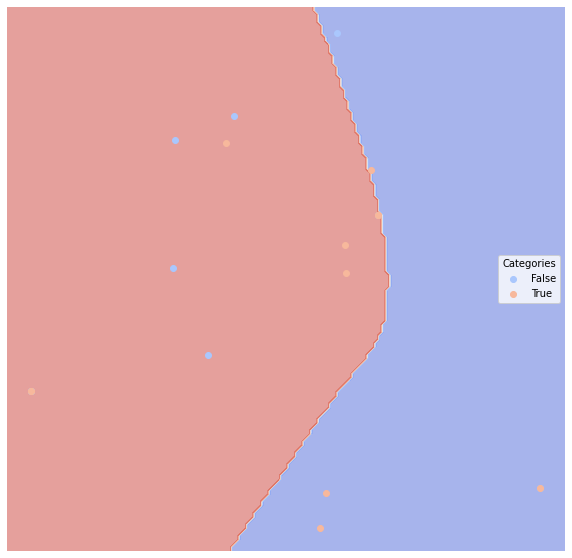

In [751]:
lucem_illud.plotregions(clf_nn, test_data_df)

The overall performance, although not satisfying, is similar to the KNN and is one of the best methods based on the statistics. 

Unlike Bayes, classical logistic regression, or any other linear modles, Neural Network is a non-linear model. It has multiple layers. It is an aggregation of perceptrons (we can sort of see a logistic regression as a single layer of the neural network model). Each time, neural network trains iteratively and update the corresponding parameters untill the final result converges (or reach maximum number of iterations), which is similar to the KNN method. 

## Classification with BERT Pipelines
Now, instead of classifying based on "old" NLP methods, we will now use the popular Transformers package default 'pipelines'. This package has methods for a wide range of common NLP tasks using contextual word embeddings. Note that for this homework, we are not building new contextual models ourselves, merely using existing models in Transformers. We will spend Weeks 7 and 8 learning more about Transformers, so do not worry about fully understanding them this week.

[Transformers Documentation](https://huggingface.co/transformers/)

[Transformers GitHub](https://github.com/huggingface/transformers)

The following sections of code are taken from the [Summary of Tasks](https://huggingface.co/transformers/task_summary.html) page in the Transformers documentation.

### Sequence Classification (e.g., sentiment)
Sequence classification is the task of classifying sequences according to a given number of classes. An example of
sequence classification is the GLUE dataset. If you would like to fine-tune a
model on a GLUE sequence classification task, you may leverage the [run_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_glue.py) and
[run_pl_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_pl_glue.py) or
[run_tf_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_tf_glue.py) scripts.

Here is an example of using pipelines to do sentiment analysis: identifying if a sentence is positive or negative. It
leverages a fine-tuned model on sst2, which is a GLUE task.

This returns a label ("POSITIVE" or "NEGATIVE") alongside a score, as follows:

In [92]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")
result = nlp("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
result = nlp("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

label: NEGATIVE, with score: 0.9991
label: POSITIVE, with score: 0.9999


Here is an example of doing a sequence classification using a model to determine if two sequences are paraphrases of
each other. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Build a sequence from the two sentences, with the correct model-specific separators token type ids and attention
   masks (`PreTrainedTokenizer.encode` and `PreTrainedTokenizer.__call__` take
   care of this).
3. Pass this sequence through the model so that it is classified in one of the two available classes: 0 (not a
   paraphrase) and 1 (is a paraphrase).
4. Compute the softmax of the result to get probabilities over the classes.
5. Print the results.

In [93]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")
classes = ["not paraphrase", "is paraphrase"]
sequence_0 = "The company HuggingFace is based in New York City"
sequence_1 = "Apples are especially bad for your health"
sequence_2 = "HuggingFace's headquarters are situated in Manhattan"
paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")
paraphrase_classification_logits = model(**paraphrase, return_dict=True).logits
not_paraphrase_classification_logits = model(**not_paraphrase, return_dict=True).logits
paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]
# Should be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")
# Should not be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

not paraphrase: 10%
is paraphrase: 90%
not paraphrase: 94%
is paraphrase: 6%


### Extractive Question Answering

Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune a
model on a SQuAD task, you may leverage the [run_squad.py](https://github.com/huggingface/transformers/tree/master/examples/question-answering/run_squad.py) and
[run_tf_squad.py](https://github.com/huggingface/transformers/tree/master/examples/question-answering/run_tf_squad.py) scripts.


Here is an example of using pipelines to do question answering: extracting an answer from a text given a question. It
leverages a fine-tuned model on SQuAD.

In [ ]:
from transformers import pipeline
nlp = pipeline("question-answering")
context = r"""
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the examples/question-answering/run_squad.py script.
"""

This returns an answer extracted from the text, a confidence score, alongside "start" and "end" values, which are the
positions of the extracted answer in the text.

In [ ]:
result = nlp(question="What is extractive question answering?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")
result = nlp(question="What is a good example of a question answering dataset?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Here is an example of question answering using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Define a text and a few questions.
3. Iterate over the questions and build a sequence from the text and the current question, with the correct
   model-specific separators token type ids and attention masks.
4. Pass this sequence through the model. This outputs a range of scores across the entire sequence of tokens (question and
   text), for both the start and end positions.
5. Compute the softmax of the result to get probabilities over the tokens.
6. Fetch the tokens from the identified start and stop values, convert those tokens to a string.
7. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""
questions = [
    "How many pretrained models are available in 🤗 Transformers?",
    "What does 🤗 Transformers provide?",
    "🤗 Transformers provides interoperability between which frameworks?",
]
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")

## <font color="red">*Exercise 7*</font>

<font color="red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

My dataset is very similar to the sentiment analysis. I ask friends to rate how negative or positive a movie reivew comment is. Thus, I want to perform the sentiment analysis.

In [47]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")

label = []
score = []

new_df = df.copy()

for row in df['text']:
    result = nlp(row)[0]
    label.append(result['label'])
    score.append(result['score'])

ERROR! Session/line number was not unique in database. History logging moved to new session 841


In [48]:
new_df['new_category'] = label
new_df['new_score'] = score
new_df

,labelled,score,text,category,tokenized_text,normalized_text,new_category,new_score
0,Y,5,Loved it! Can’t wait until I can buy it and wa...,True,"[Loved, it, Ca, n’t, wait, until, I, can, buy,...","[loved, wait, buy, watch, want]",POSITIVE,0.999787
1,Y,5,"wowwww really good movie, you see you can make...",True,"[wowwww, really, good, movie, you, see, you, c...","[wowwww, good, movie, movies, honor, fans, cha...",POSITIVE,0.999824
2,Y,4,Started slow but got better!,True,"[Started, slow, but, got, better]","[started, slow, got, better]",POSITIVE,0.982307
3,Y,3,Spiderman: Into the Spiderverse did it better ...,False,"[Spiderman, Into, the, Spiderverse, did, it, b...","[spiderman, spiderverse, better, entertaining,...",POSITIVE,0.996211
4,Y,5,whole movie was great,True,"[whole, movie, was, great]","[movie, great]",POSITIVE,0.999869
...,...,...,...,...,...,...,...,...
65,N,0,Just ok. Storyline was kinda slow,False,"[Just, ok, Storyline, was, kinda, slow]","[ok, storyline, kinda, slow]",POSITIVE,0.505506
66,N,0,Was exciting! Liked special effects! Good posi...,False,"[Was, exciting, Liked, special, effects, Good,...","[exciting, liked, special, effects, good, posi...",POSITIVE,0.999473
67,N,0,Worst movie ive ever watched. Its just so frus...,False,"[Worst, movie, i, ve, ever, watched, Its, just...","[worst, movie, ve, watched, frustrating, watch...",NEGATIVE,0.999751
68,N,0,best acting in a superhero film.,False,"[best, acting, in, a, superhero, film]","[best, acting, superhero, film]",POSITIVE,0.999644


In [50]:
new_df_coded = new_df.loc[new_df['labelled'] == 'Y']
new_df_coded

,labelled,score,text,category,tokenized_text,normalized_text,new_category,new_score
0,Y,5,Loved it! Can’t wait until I can buy it and wa...,True,"[Loved, it, Ca, n’t, wait, until, I, can, buy,...","[loved, wait, buy, watch, want]",POSITIVE,0.999787
1,Y,5,"wowwww really good movie, you see you can make...",True,"[wowwww, really, good, movie, you, see, you, c...","[wowwww, good, movie, movies, honor, fans, cha...",POSITIVE,0.999824
2,Y,4,Started slow but got better!,True,"[Started, slow, but, got, better]","[started, slow, got, better]",POSITIVE,0.982307
3,Y,3,Spiderman: Into the Spiderverse did it better ...,False,"[Spiderman, Into, the, Spiderverse, did, it, b...","[spiderman, spiderverse, better, entertaining,...",POSITIVE,0.996211
4,Y,5,whole movie was great,True,"[whole, movie, was, great]","[movie, great]",POSITIVE,0.999869
5,Y,2,the only cool thing is Dr Strange thing. didn'...,False,"[the, only, cool, thing, is, Dr, Strange, thin...","[cool, thing, dr, strange, thing, like, plot, ...",NEGATIVE,0.998073
6,Y,4,I really enjoyed the movie. I didn't know the ...,True,"[I, really, enjoyed, the, movie, I, did, n't, ...","[enjoyed, movie, know, plot, cool, bring, past...",POSITIVE,0.999805
7,Y,2,I thought it was slow and didnt have the usual...,False,"[I, thought, it, was, slow, and, did, nt, have...","[thought, slow, nt, usual, spider, man, movie,...",NEGATIVE,0.999675
8,Y,2,Have liked all the other Spiderman movies. Thi...,False,"[Have, liked, all, the, other, Spiderman, movi...","[liked, spiderman, movies, bit, far, spidermen...",NEGATIVE,0.998653
9,Y,5,action packed and full of surprises!!!,True,"[action, packed, and, full, of, surprises]","[action, packed, surprises]",POSITIVE,0.999863


ERROR! Session/line number was not unique in database. History logging moved to new session 842


In [59]:
new_df_coded['new_score'] = new_df_coded['new_score'].where(new_df_coded['new_category']=="NEGATIVE", (-new_df_coded['new_score'].astype(float)))

/Users/luzhang/opt/anaconda3/envs/content/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='score', ylabel='new_score'>

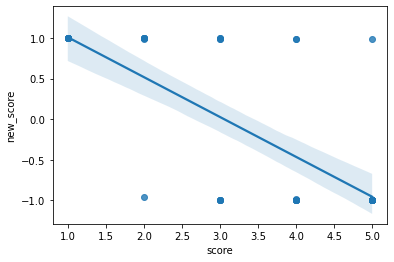

In [60]:
seaborn.regplot(x='score', y='new_score', data=new_df_coded)

In assumption, since `5` correspond to `positive` while `1` correspond to `negative`, we should see a lower sentiment score (`new_score` column) for the `1`s, and higher sentiment score for the `5`s. However, the trend is opposite to the assumption. We probably need a longer paragraph for sentiment analysis to be correct. Also, since they are all comments on the internet and are not complete sentence, it may be true that those comments cannot be fully understand by sentiment analysis. 